# Cat vs. Dog Image Classification with Transfer Learning MobileNetV2 99% 
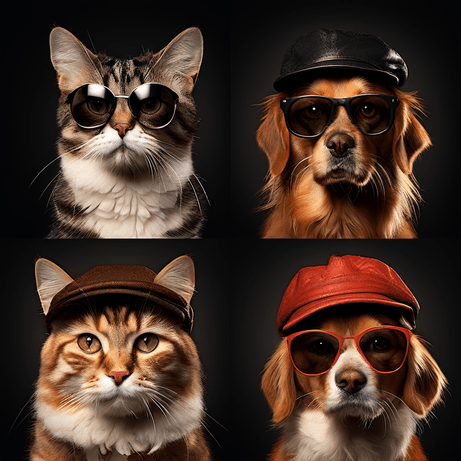


## Introduction

In this project, I will be building an image classification model to distinguish between pictures of cats and dogs. By leveraging transfer learning, I plan to use a pre-trained neural network as the starting point for my model, which can significantly expedite the training process and enhance the model's accuracy. Transfer learning is particularly beneficial when dealing with a limited dataset, as it allows me to apply knowledge gained from a comprehensive model trained on extensive data to my specific task.

My goals are to:

- Gain a deeper understanding of transfer learning and its benefits in machine learning.
- Implement transfer learning using a pre-trained model to recognize cats and dogs in images.
- Train and fine-tune the model to achieve high accuracy on the cat and dog dataset.
- Assess the model's performance through rigorous testing.

## Dataset Overview

The dataset I'll be using consists of numerous images classified into two categories: cats and dogs. Each image has been labeled to facilitate a binary classification task. These images provide a rich dataset for training the classifier.

Notable details about the dataset include:

- The total count of images for each category.
- The origin of the dataset.
- The image formats and their resolutions.
- The preprocessing steps necessary to ready the data for the training process.

## Acknowledgements

I would like to express my sincere thanks to the individuals and organizations responsible for the creation and maintenance of the dataset I am using in this project. A special acknowledgment goes out to [Source/Dataset Provider] for making this valuable resource available to the public. This project is a testament to the collaborative nature of the machine learning community, and I am grateful to be able to contribute to its ongoing progress.

<h1 style="color: #ff6347; text-align: center; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Cat vs. Dog Classification Project 🐶
</h1>

In [41]:
import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, \
    Conv2D, \
    MaxPooling2D, \
    Flatten, \
    BatchNormalization, \
    Dropout,\
    Rescaling
# from keras.preprocessing import ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [42]:
img_height = 256
img_width = 256
batch_size = 32

<h1 style="color: #ff6347; text-align: left; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Loading and Preprocessing the Data 🐶
</h1>

In [43]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/dogs-vs-cats/train',
    labels='inferred',
    label_mode='int', # Cats and dogs will get their own integer labels
    batch_size=batch_size,
    image_size=(img_height,img_width)
)
# /kaggle/input/dogs-vs-cats/test
validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/dogs-vs-cats/test',
    labels='inferred',
    label_mode='int', # Cats and dogs will get their own integer labels
    batch_size=batch_size,
    image_size=(img_height,img_width)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


<h1 style="color: #ff6347; text-align: left; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Splitting Validation Data into Test and Validation Sets 🐶
</h1>

In [44]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches//5)
val_ds = validation_ds.skip(val_batches//5)

In [45]:
print(f'No. of validation batches = {tf.data.experimental.cardinality(val_ds)}')
print(f'No. of validation batches = {tf.data.experimental.cardinality(test_ds)}')

No. of validation batches = 126
No. of validation batches = 31


In [46]:
class_names = train_ds.class_names
class_names

In [48]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


<h1 style="color: #ff6347; text-align: ; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Visualizing Training Data Samples 🐶
</h1>

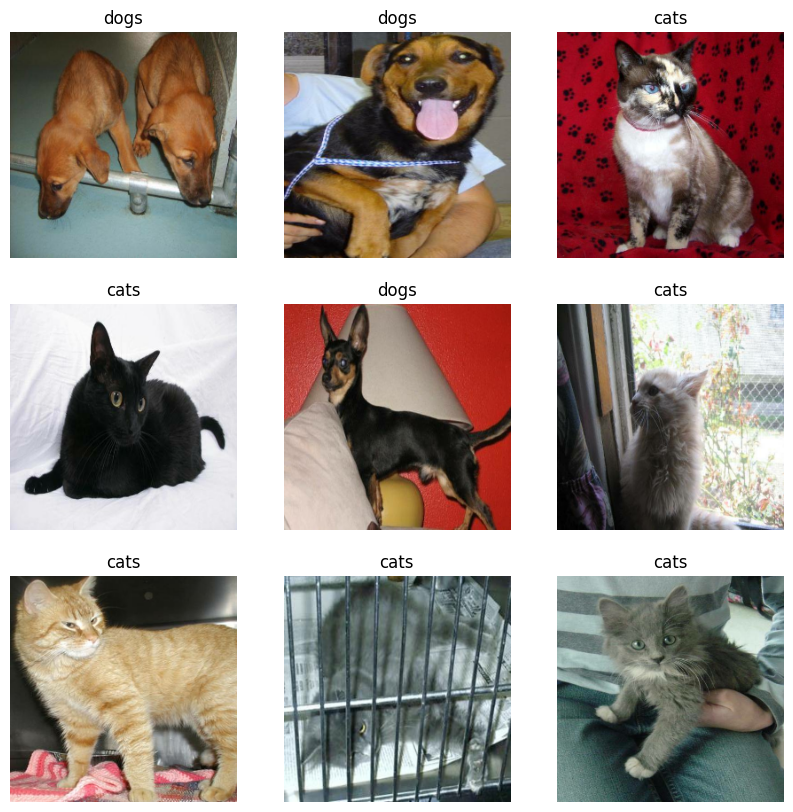

In [49]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

<h1 style="color: #ff6347; text-align: left; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Optimizing Data Pipeline for Performance 🐶
</h1>

In [50]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

<h1 style="color: #ff6347; text-align: left; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Preprocessing: Image Resizing and Rescaling 🐶
</h1>

In [51]:
IMG_SIZE = 256

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255, offset=-1)
])

In [52]:
IMG_SHAPE = (img_height, img_width) + (3,)
IMG_SHAPE

(256, 256, 3)

<h1 style="color: #ff6347; text-align: left; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Implementing Data Augmentation Techniques 🐶
</h1>

In [53]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", 
                      input_shape=(img_height,
                                   img_width,
                                   1)),
    layers.RandomRotation(0.1), # Randomly rotates inputs by 0.1 radians
    layers.RandomZoom(0.1), # Randomly zooms inputs by 10%
    layers.RandomContrast(0.2), # Randomly changes the contrast of inputs by 20%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Randomly translates the image vertically and horizontally by 10%
    layers.RandomHeight(0.1), # Randomly changes the height by 10%
    layers.RandomWidth(0.1), # Randomly changes the width by 10%
    layers.RandomBrightness(0.2), # Randomly changes brightness by 20%
    # Potentially add more layers like random shear or color transformations
  ]
)


<h1 style="color: #ff6347; text-align: left; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Integrating MobileNetV2 as Base Model 🐶
</h1>

In [54]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [55]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

print(f'Our final feature map is: {feature_batch.shape}')


Our final feature map is: (32, 8, 8, 1280)


In [56]:
base_model.trainable = False

In [57]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[

<h1 style="color: #ff6347; text-align: left; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Adding Global Pooling Layer to the Model 🐶
</h1>

In [58]:
global_average_layer = tf.keras.layers.GlobalMaxPooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


<h1 style="color: #ff6347; text-align: left; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Assembling the Full Model Architecture 🐶
</h1>

In [59]:
# Define the input layer with the shape of your images
inputs = tf.keras.Input(shape=(img_height, img_width, 3))

# Apply data augmentation
x = data_augmentation(inputs)

# Apply resize and rescale operations
x = resize_and_rescale(x)

# Pass the data through the base model
x = base_model(x, training=False)

# Apply global average pooling to flatten the output of the base model
x = global_average_layer(x)

# Add a new dense layer with 1280 units and ReLU activation
x = tf.keras.layers.Dense(1280, activation='relu')(x)

# Add another dense layer with 512 units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Add another dropout layer
x = tf.keras.layers.Dropout(0.1)(x)  # Dropout rate of 10%

# Add the final prediction layer
outputs = tf.keras.layers.Dense(1)(x)  # Single neuron for output

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Now you can see the summary of your model
print(model.summary())



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, None, None, 1)     0         
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_max_pooling2d_1 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_3 (Dense)             (None, 1280)              1639

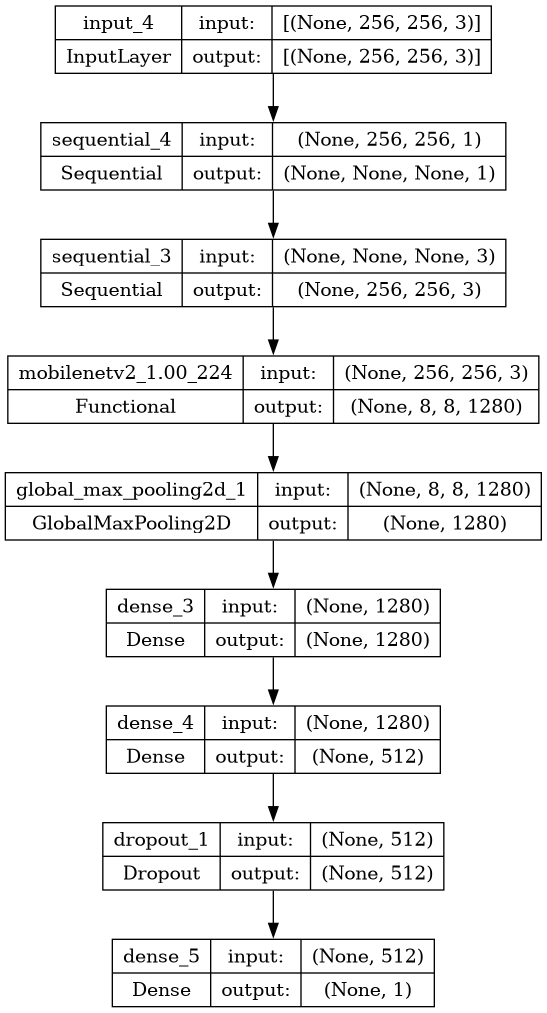

In [60]:
tf.keras.utils.plot_model(model, show_shapes=True)

<h1 style="color: #ff6347; text-align: left; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Training the Model with Early Stopping 🐶
</h1>

In [61]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])


In [62]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_ds)

126/126 [==============================] - 8s 51ms/step - loss: 0.9682 - accuracy: 0.4820


In [63]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True)

In [64]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 0.97
initial accuracy: 0.48


In [65]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/10
625/625 [==============================] - 52s 73ms/step - loss: 0.2803 - accuracy: 0.8852 - val_loss: 0.0586 - val_accuracy: 0.9793
Epoch 2/10
625/625 [==============================] - 46s 73ms/step - loss: 0.2218 - accuracy: 0.9071 - val_loss: 0.0464 - val_accuracy: 0.9838
Epoch 3/10
625/625 [==============================] - 46s 73ms/step - loss: 0.1984 - accuracy: 0.9144 - val_loss: 0.0552 - val_accuracy: 0.9793
Epoch 4/10
625/625 [==============================] - 46s 73ms/step - loss: 0.1878 - accuracy: 0.9217 - val_loss: 0.0464 - val_accuracy: 0.9828
Epoch 5/10
625/625 [==============================] - 46s 74ms/step - loss: 0.1813 - accuracy: 0.9250 - val_loss: 0.0435 - val_accuracy: 0.9815
Epoch 6/10
625/625 [==============================] - 46s 73ms/step - loss: 0.1852 - accuracy: 0.9230 - val_loss: 0.0488 - val_accuracy: 0.9833
Epoch 7/10
625/625 [==============================] - 46s 73ms/step - loss: 0.1764 - accuracy: 0.9268 - val_loss: 0.0436 - val_accuracy:

<h1 style="color: #ff6347; text-align: left; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Analyzing Training and Validation Metrics 🐶
</h1>

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


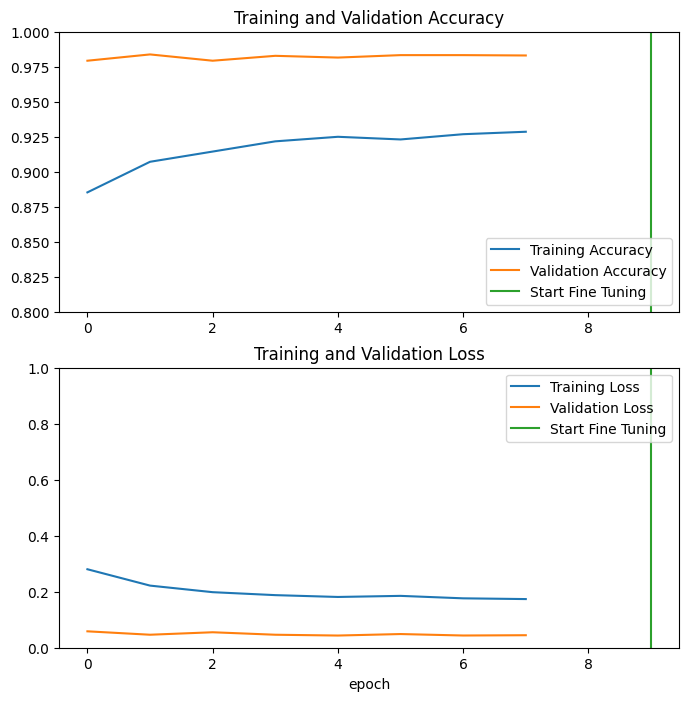

In [67]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


<h1 style="color: #ff6347; text-align: left; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Fine-Tuning the Model for Enhanced Performance 🐶
</h1>

In [68]:
base_model.trainable = True


In [69]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  154


In [70]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])


In [71]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True)


model_checkpoint = ModelCheckpoint(
    'path/to/save/model.{epoch:02d}-{val_loss:.2f}.h5',  
    save_best_only=True,                                 
    monitor='val_loss',                                  
    mode='min',                                          
    verbose=1)   

callbacks_list = [early_stopping, model_checkpoint]

In [72]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds, callbacks=callbacks_list)


Epoch 8/20
625/625 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9324
Epoch 8: val_loss improved from inf to 0.04636, saving model to path/to/save/model.08-0.05.h5
625/625 [==============================] - 63s 87ms/step - loss: 0.1637 - accuracy: 0.9324 - val_loss: 0.0464 - val_accuracy: 0.9828
Epoch 9/20
625/625 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.9409
Epoch 9: val_loss improved from 0.04636 to 0.03910, saving model to path/to/save/model.09-0.04.h5
625/625 [==============================] - 53s 85ms/step - loss: 0.1443 - accuracy: 0.9409 - val_loss: 0.0391 - val_accuracy: 0.9855
Epoch 10/20
625/625 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9465
Epoch 10: val_loss did not improve from 0.03910
625/625 [==============================] - 53s 84ms/step - loss: 0.1330 - accuracy: 0.9465 - val_loss: 0.0438 - val_accuracy: 0.9843
Epoch 11/20
625/625 [==============================] - ETA: 0s - loss: 0

In [73]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

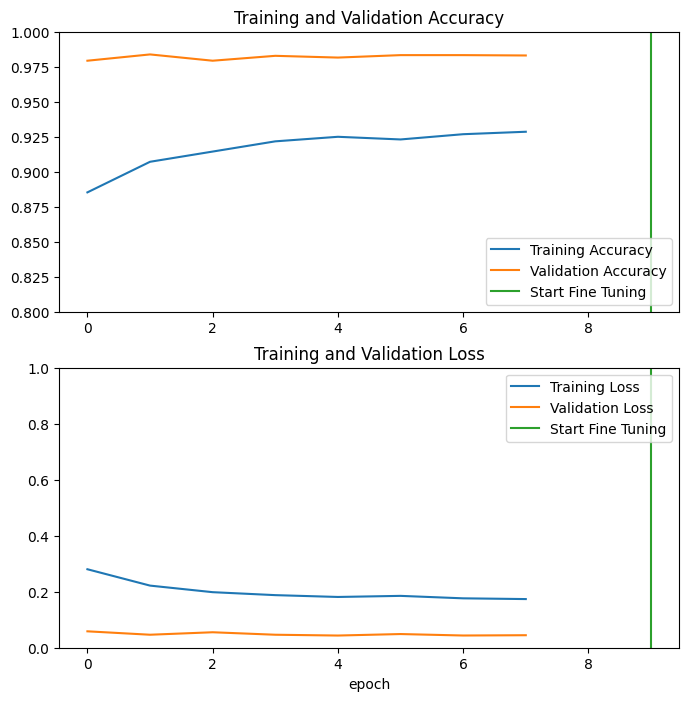

31/31 [==============================] - 2s 52ms/step - loss: 0.0482 - accuracy: 0.9869
Test accuracy : 0.9868951439857483


In [74]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)


<h1 style="color: #ff6347; text-align: left; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Model Evaluation on Test Data 🐶
</h1>

In [75]:
loss, accuracy = model.evaluate(test_ds)
print("-"*60)
print('Test accuracy :', accuracy)



31/31 [==============================] - 2s 52ms/step - loss: 0.0429 - accuracy: 0.9879
------------------------------------------------------------
Test accuracy : 0.9879032373428345


<h1 style="color: #ff6347; text-align: left; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Making Predictions on Test Images 🐶
</h1>

Predictions:
 [1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0]
Labels:
 [1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0]


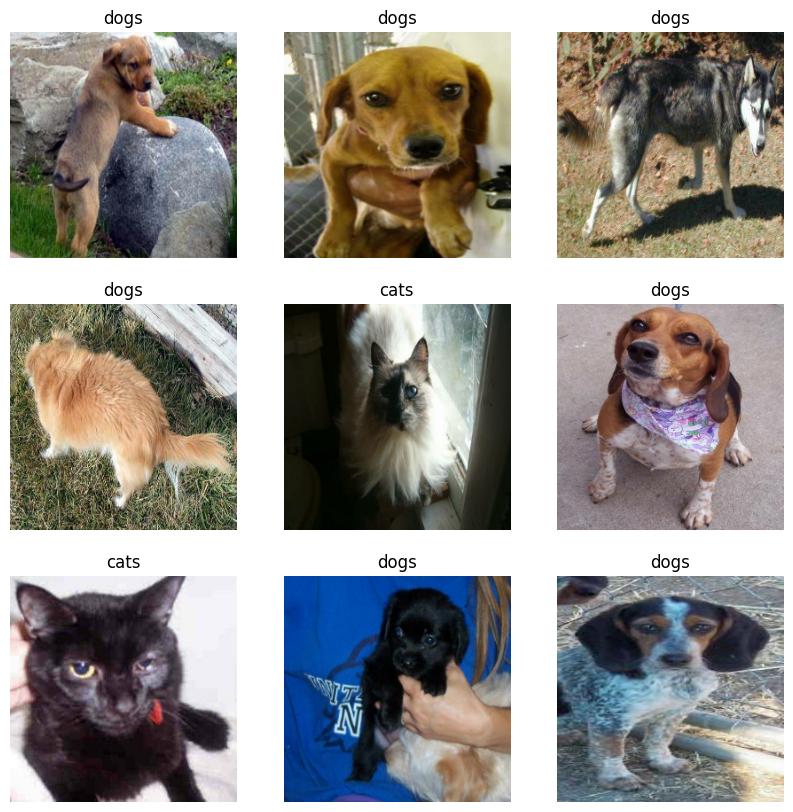

In [76]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


<h1 style="color: #ff6347; text-align: left; font-family: 'Lucida Console', Monaco, monospace;">
    🐱 Conclusion🐶
</h1>

I achieved a test accuracy of 98.79%, nearly 99%, indicating that my model performs well at image classification.  This accuracy score is a strong indicator that the model has effectively captured the key features necessary to distinguish between the classes in the dataset and can generalize its learning to accurately predict on new, unseen data.